# Preprocsss

## 一、填補資料
一、首先我先將資料匯入到資料庫中
```mysql
create table cbike(
	trip_duration int,
	start_time datetime,
	stop_time datetime,
	start_id varchar(10),
	start_name varchar(100),
	start_latitude float,
	start_longitude float,
	end_id varchar(10),
	end_name varchar(100),
	end_latitude float,
	end_longitude float,
	bike_id varchar(10),
	user_type varchar(20),
	birth_year int,
	gender varchar(5),
	index(start_id,start_time,stop_time,end_id)
);

load data local infile './201707-citibike-tripdata.csv'
into table cbike
fields terminated by ','
enclosed by '"'
lines terminated by '\n'
ignore 1 lines;
```

二、再來查詢所有欄位中，值是NULL或者是0的情況，發現只有birth_year和gender資料有遺失，而且兩個問題不一定會同時出現

gender的資料遺失的問題，先查詢了gender和usertype個數的關聯

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data=pd.read_csv('./201707-citibike-tripdata.csv')
print(data.groupby(['gender','usertype'])['bikeid'].count())

gender  usertype  
0       Customer       214133
        Subscriber      21061
1       Customer        30085
        Subscriber    1069299
2       Customer        17494
        Subscriber     383527
Name: bikeid, dtype: int64


於是決定以這些數據來random出遺失的gender數據

而用SQL查詢遺失的birth_year與其他現有資料
```sql
select birth_year,count(*) from cbike group by birth_year order by count(*) desc;
```
會發現NULL值竟有228596筆，而第二多的數值是1988年，只有68620筆，因此決定不管這些NULL值，不然結果可能會不太准
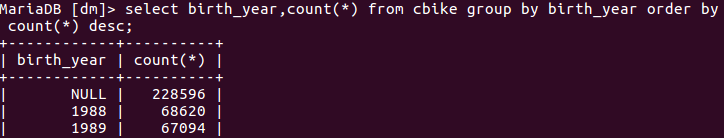

接者開始填補gender
```python
import pandas as pd
import random as rd

data=pd.read_csv('./201707-citibike-tripdata.csv')
for index,i in data.iterrows():
	if(data.loc[index,'gender']==0):
		if(data.loc[index,'usertype']=='Customer'):
			r=rd.randint(1,47580)
			if(r<=30085):
				data.loc[index,'gender']=1
			else:
				data.loc[index,'gender']=2
		if(data.loc[index,'usertype']=='Subscriber'):
			r=rd.randint(1,1452827)
			if(r<=1069299):
				data.loc[index,'gender']=1
			else:
				data.loc[index,'gender']=2
data.to_csv('./new_data.csv')
```

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data=pd.read_csv('./new_data.csv')
print(data.groupby(['gender','usertype'])['bikeid'].count())

gender  usertype  
1       Customer       165219
        Subscriber    1084872
2       Customer        96493
        Subscriber     389015
Name: bikeid, dtype: int64


三、最後我查詢兩站id相同，但名稱不同的情況，發現是empty set。真是個乾淨的資料阿
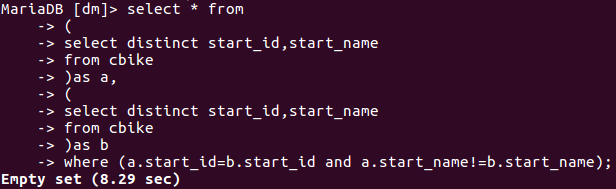
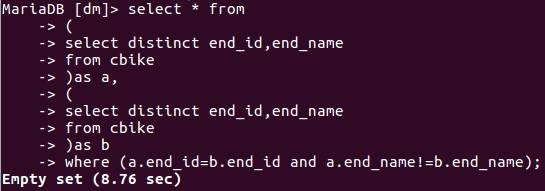

##  二、資料分群

首先先來看station id最多會到多少

In [1]:
import pandas as pd
data=pd.read_csv('./new_data.csv')
a=data.loc[:,['start station id','end station id']]
print(a.max())

start station id    3478
end station id      3478
dtype: int64


於是乎

我先為in_flow和out_flow各開足夠大的list，三個維度分別是 'id','日期','當天時間的編號;
```python
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

data=pd.read_csv('./new_data.csv')
in_flow=np.zeros((3479,32,48),dtype='i')
out_flow=np.zeros((3479,32,48),dtype='i')
```
再來讀檔，並對每一列分析後放入in_flow和out_flow
```python
a=data.loc[:,['start station id','starttime','end station id','stoptime']]

for i in a.itertuples():
	t=time.strptime(str(i[2]),"%Y-%m-%d %H:%M:%S")
	j=int(i[1])
	k=int(t.tm_mday)
	l=int(t.tm_hour*2+t.tm_min/30)
	out_flow[j][k][l]=out_flow[j][k][l]+1
	t=time.strptime(str(i[4]),"%Y-%m-%d %H:%M:%S")
	j=int(i[3])
	k=int(t.tm_mday)
	l=int(t.tm_hour*2+t.tm_min/30)
	in_flow[j][k][l]=in_flow[j][k][l]+1
```
最後寫入檔案，而在time的欄位，我選擇將他變成"日期*48+那天時段"，讓他變成一串連續的數字
```python
with open('inout_flow_data.csv','w') as x:
	o=csv.writer(x)
	o.writerow(['station_id','time','in_flow_count','out_flow_count'])
	for i in range(1,3479):
		for j in range(1,32):
			for k in range(48):
				o.writerow([i,(j-1)*48+k,in_flow[i][j][k],out_flow[i][j][k]])
```


# Query

## Q1. stations number and their average distance

**number=634**
```sql
select count(*) from
(
	select distinct start_id from cbike
	union
	select distinct end_id from cbike
) as a;
```
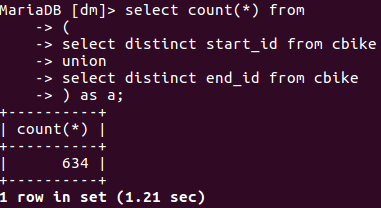

第二小題的可以分成兩部份，第一部份是讀檔案和篩出唯一的station
第二部份是計算距離，這裡我用了python裡的great_circle和vincenty兩種function

In [2]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle,vincenty

data=pd.read_csv('./new_data.csv')

name={
'start station id':'id',
'start station latitude':'latitude',
'start station longitude':'longitude'}
s=data.loc[:,['start station id','start station latitude','start station longitude']]
s=s.rename(columns=name)
name={
'end station id':'id',
'end station latitude':'latitude',
'end station longitude':'longitude'}
s2=data.loc[:,['end station id','end station latitude','end station longitude']]
s2=s2.rename(columns=name)
s=s.append(s2).drop_duplicates('id').sort_values('id')

suv=0
sug=0
for i in s.itertuples():
	for j in s.itertuples():
		if(j[1]<=i[1]):
			continue
		suv=suv+vincenty((i[2],i[3]),(j[2],j[3])).meters
		sug=sug+great_circle((i[2],i[3]),(j[2],j[3])).meters
print('average of vincenty: '+str(suv/634/633*2))
print('average of great_circle: '+str(sug/634/633*2))


average of vincenty: 5435.0130508862985
average of great_circle: 5438.889938430181


## Q2. Top three frequent stations pairs

In weekdays:
** (3254,3182) (3182,3254) (3254,3254) **
```sql
select start_id,end_id,count(*)
from cbike
group by start_id,end_id
order by count(*) desc
limit 3;
```
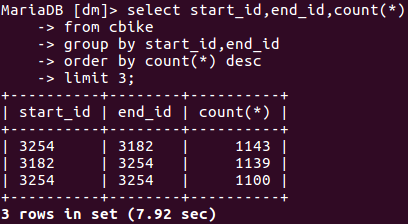

In weekends:
** (3182,3182) (3182,3254) (3254,3182) **

(不考慮start_time為假日，stop_time為平日的情況）
```sql
select start_id,end_id,count(*)
from cbike
where
start_time like '2017-07-01%' or
start_time like '2017-07-02%' or
start_time like '2017-07-08%' or
start_time like '2017-07-09%' or
start_time like '2017-07-15%' or
start_time like '2017-07-16%' or
start_time like '2017-07-22%' or
start_time like '2017-07-23%' or
start_time like '2017-07-29%' or
start_time like '2017-07-30%'
group by start_id,end_id
order by count(*) desc
limit 3;
```
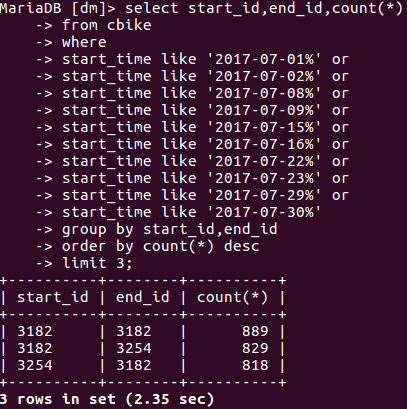

## Q3. Top three highest average in/out flow

** out_flow: 519,426,514 **

** in_flow : 426,519,514 **

首先先建立和匯入先前產生的時序資料到DB裡面
```sql
create table iodata(
	id varchar(10),
	tm int,
	in_c int,
	out_c int,
	primary key(id,tm),
	index(id)
);

load data local infile './inout_flow_data.csv'
into table iodata
fields terminated by ','
enclosed by '"'
lines terminated by '\n'
ignore 1 lines;
```
再來就可以查詢了
```sql
select id,sum(out_c)/1488 from iodata
group by id 
order by sum(out_c)/1488 desc
limit 3;

select id,sum(in_c)/1488 from iodata
group by id 
order by sum(in_c)/1488 desc
limit 3;
```
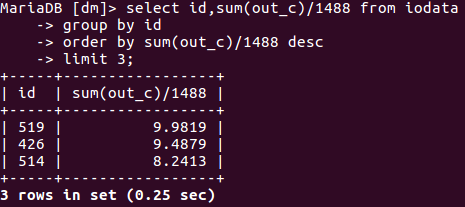
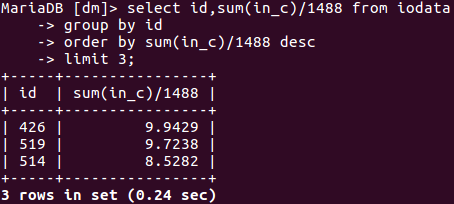

## Q4. Most popular station

### Most popular station
** Most popular station: 519 **
```sql
select id,sum(out_c+in_c)/2976 from iodata
group by id 
order by sum(out_c+in_c)/2976 desc
limit 1;
```
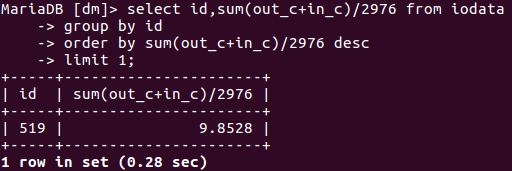

### 519 in/out flow count chart

圖中的灰線是區隔每天時間的輔助線

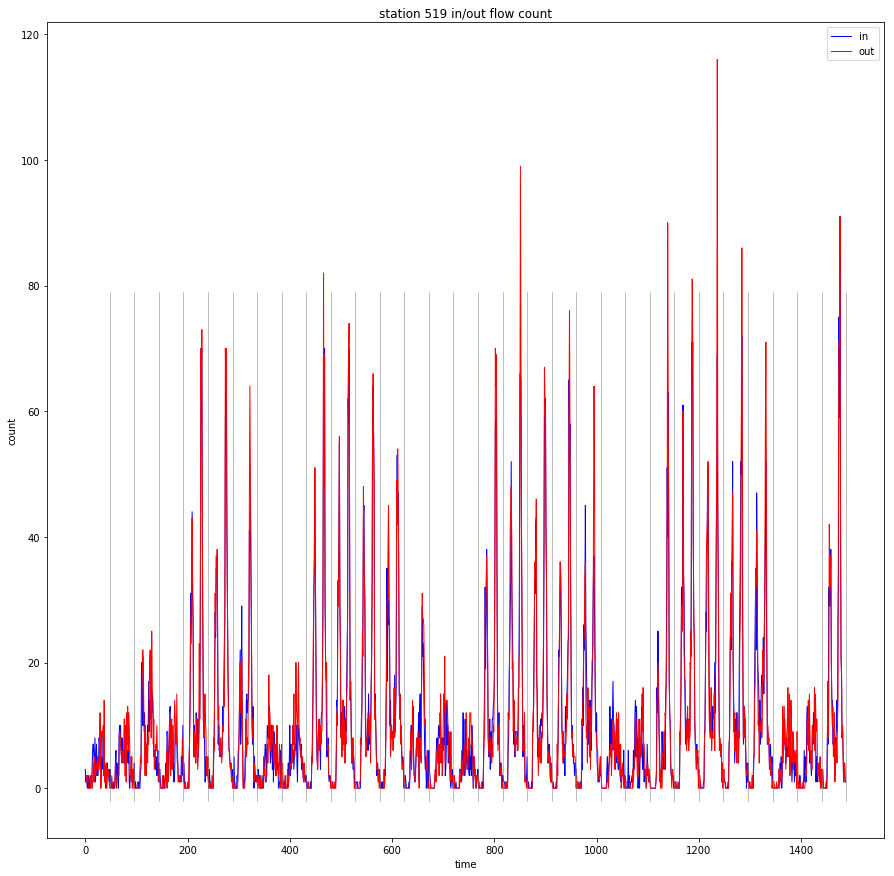

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('./inout_flow_data.csv')

d=data.loc[data['station_id']==519,:]
plt.figure(figsize=(15,15))
plt.plot(d['time'],d['in_flow_count'],color='blue',label='in',linewidth=1.0)
plt.plot(d['time'],d['out_flow_count'],color='red',label='out',linewidth=1.0)
a=[]
for i in range(-2,80):
    a.append(i)
for i in range(1,32):
	plt.plot([48*i]*82,a,color='gray',linewidth=0.5)
plt.title('station 519 in/out flow count')
plt.xlabel('time')
plt.ylabel('count')
plt.legend()
plt.show()

### Distance between in-flow and out-flow

** Distance: 178.56 ** (By euclidean distance)

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

data=pd.read_csv('./inout_flow_data.csv')
d=data.loc[data['station_id']==519,:]
print(pairwise_distances([d['in_flow_count'],d['out_flow_count']],metric='euclidean'))

[[   0.          178.55531356]
 [ 178.55531356    0.        ]]


### Minus their average

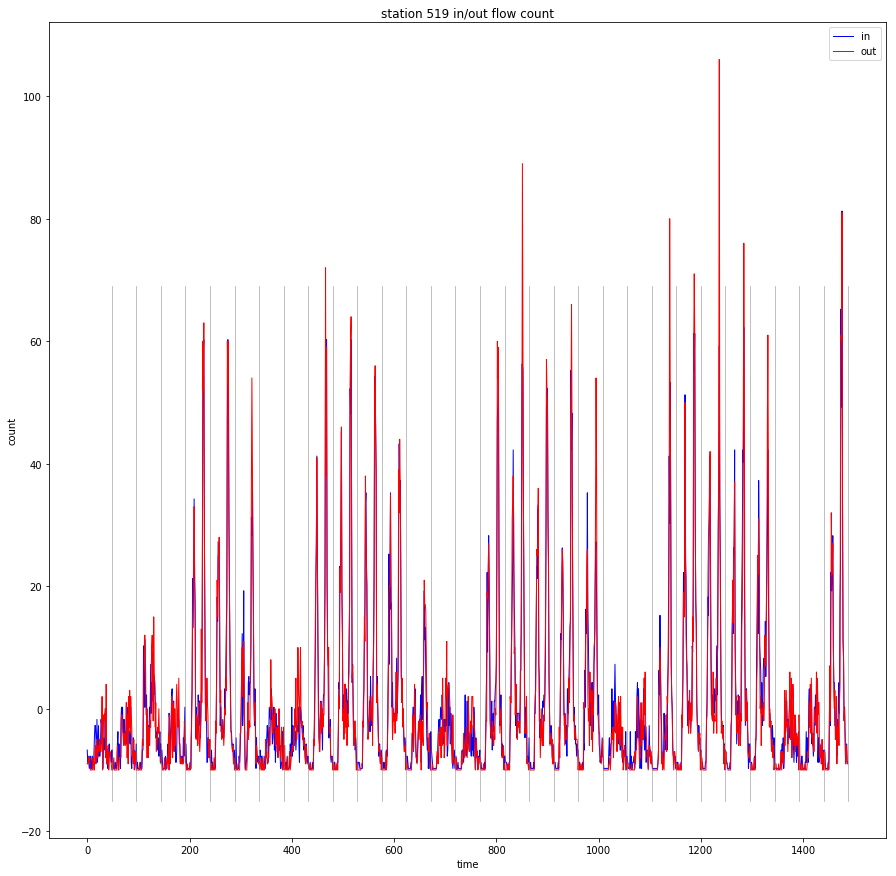

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data=pd.read_csv('./inout_flow_data.csv')

d=data.loc[data['station_id']==519,:]
plt.figure(figsize=(15,15))
im=np.mean(d['in_flow_count'])
om=np.mean(d['out_flow_count'])
plt.plot(d['time'],d['in_flow_count']-im,color='blue',label='in',linewidth=1.0)
plt.plot(d['time'],d['out_flow_count']-om,color='red',label='out',linewidth=1.0)
a=[]
for i in range(-15,70):
    a.append(i)
for i in range(1,32):
	plt.plot([48*i]*85,a,color='gray',linewidth=0.5)
plt.title('station 519 in/out flow count')
plt.xlabel('time')
plt.ylabel('count')
plt.legend()
plt.show()

** Distance: 178.28 ** (By euclidean distance)

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances


data=pd.read_csv('./inout_flow_data.csv')

d=data.loc[data['station_id']==519,:]
im=np.mean(d['in_flow_count'])
om=np.mean(d['out_flow_count'])
print(pairwise_distances([d['in_flow_count']-im,d['out_flow_count']-om],metric='euclidean'))

[[   0.          178.27760158]
 [ 178.27760158    0.        ]]


### Minus their average and divide their standard deviation

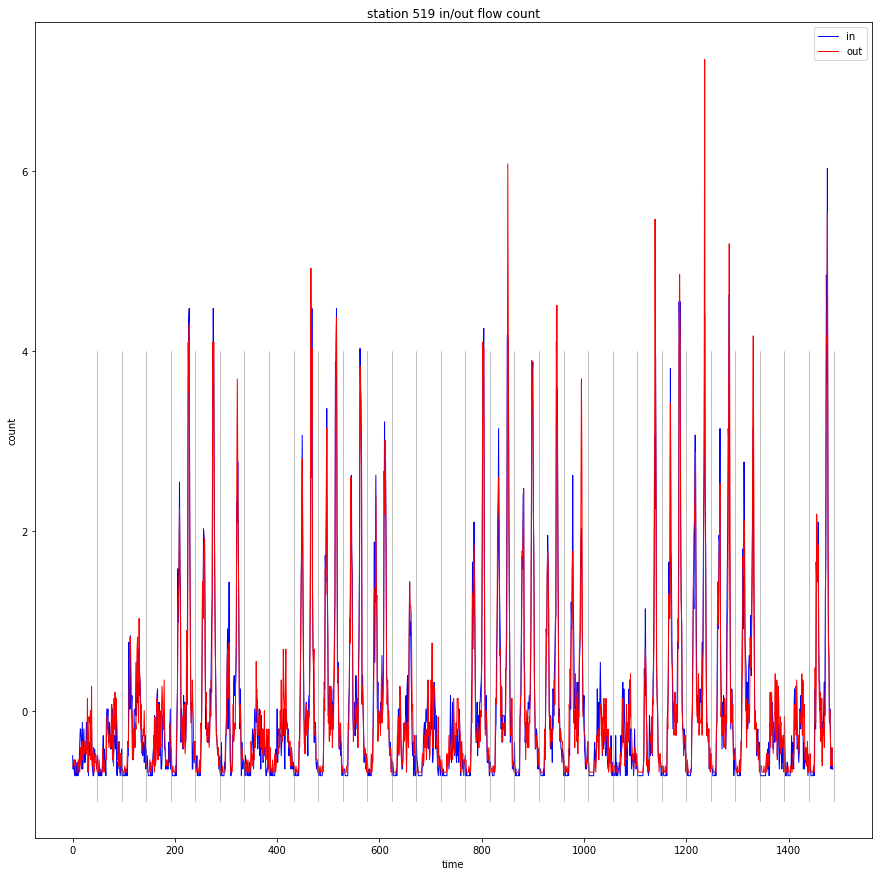

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data=pd.read_csv('./inout_flow_data.csv')

d=data.loc[data['station_id']==519,:]
plt.figure(figsize=(15,15))
im=np.mean(d['in_flow_count'])
isd=np.std(d['in_flow_count'])
om=np.mean(d['out_flow_count'])
osd=np.std(d['out_flow_count'])
plt.plot(d['time'],(d['in_flow_count']-im)/isd,color='blue',label='in',linewidth=1.0)
plt.plot(d['time'],(d['out_flow_count']-om)/osd,color='red',label='out',linewidth=1.0)
a=[]
for i in range(-1,5):
    a.append(i)
for i in range(1,32):
	plt.plot([48*i]*6,a,color='gray',linewidth=0.5)
plt.title('station 519 in/out flow count')
plt.xlabel('time')
plt.ylabel('count')
plt.legend()
plt.show()

** Distance: 12.28 ** (By euclidean distance)

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances


data=pd.read_csv('./inout_flow_data.csv')

d=data.loc[data['station_id']==519,:]
im=np.mean(d['in_flow_count'])
isd=np.std(d['in_flow_count'])
om=np.mean(d['out_flow_count'])
osd=np.std(d['out_flow_count'])
print(pairwise_distances([(d['in_flow_count']-im)/isd,(d['out_flow_count']-om)/osd],metric='euclidean'))

[[  0.          12.28106763]
 [ 12.28106763   0.        ]]


### Minus their prediction

** Distance: 178.27 ** (By euclidean distance)

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import linear_model

data=pd.read_csv('./inout_flow_data.csv')

reg=linear_model.LinearRegression()
d=data.loc[data['station_id']==519,:]

x=d['time']
i=d['in_flow_count']
o=d['out_flow_count']
x=x.values.reshape([len(x),1])
i=i.values.reshape([len(i),1])
o=o.values.reshape([len(o),1])
reg.fit(x,i)
inp=reg.predict(x)
reg.fit(x,o)
outp=reg.predict(x)
inp=np.reshape(inp,len(inp))
outp=np.reshape(outp,len(outp))
i=np.reshape(i,len(i))
o=np.reshape(o,len(o))

print(pairwise_distances([i-inp,o-outp],metric='euclidean'))

[[  2.15791864e-05   1.78272088e+02]
 [  1.78272088e+02   0.00000000e+00]]


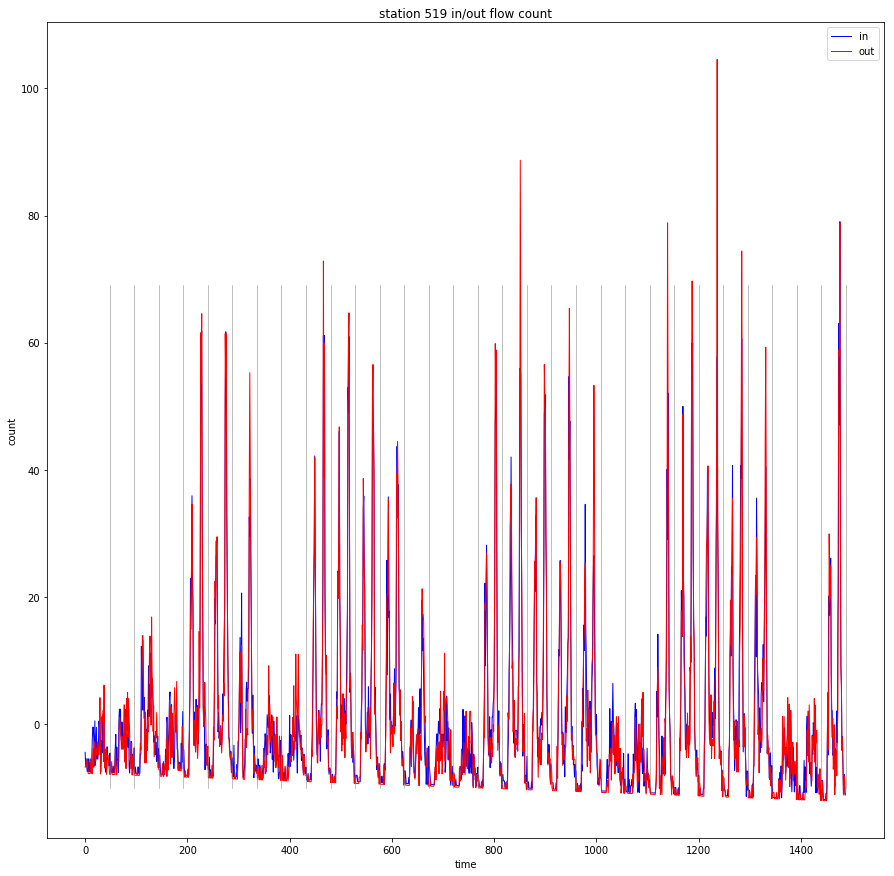

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model


data=pd.read_csv('./inout_flow_data.csv')

reg=linear_model.LinearRegression()
d=data.loc[data['station_id']==519,:]

x=d['time']
i=d['in_flow_count']
o=d['out_flow_count']
x=x.values.reshape([len(x),1])
i=i.values.reshape([len(i),1])
o=o.values.reshape([len(o),1])
reg.fit(x,i)
inp=reg.predict(x)
reg.fit(x,o)
outp=reg.predict(x)
inp=np.reshape(inp,len(inp))
outp=np.reshape(outp,len(outp))
i=np.reshape(i,len(i))
o=np.reshape(o,len(o))
x=np.reshape(x,len(x))

plt.figure(figsize=(15,15))
plt.plot(x,i-inp,color='blue',label='in',linewidth=1.0)
plt.plot(x,o-outp,color='red',label='out',linewidth=1.0)
a=[]
for i in range(-10,70):
    a.append(i)
for i in range(1,32):
	plt.plot([48*i]*80,a,color='gray',linewidth=0.5)
plt.title('station 519 in/out flow count')
plt.xlabel('time')
plt.ylabel('count')
plt.legend()
plt.show()

### Smooth Data

在這邊我是用statsmodels的lowess來平滑這張圖

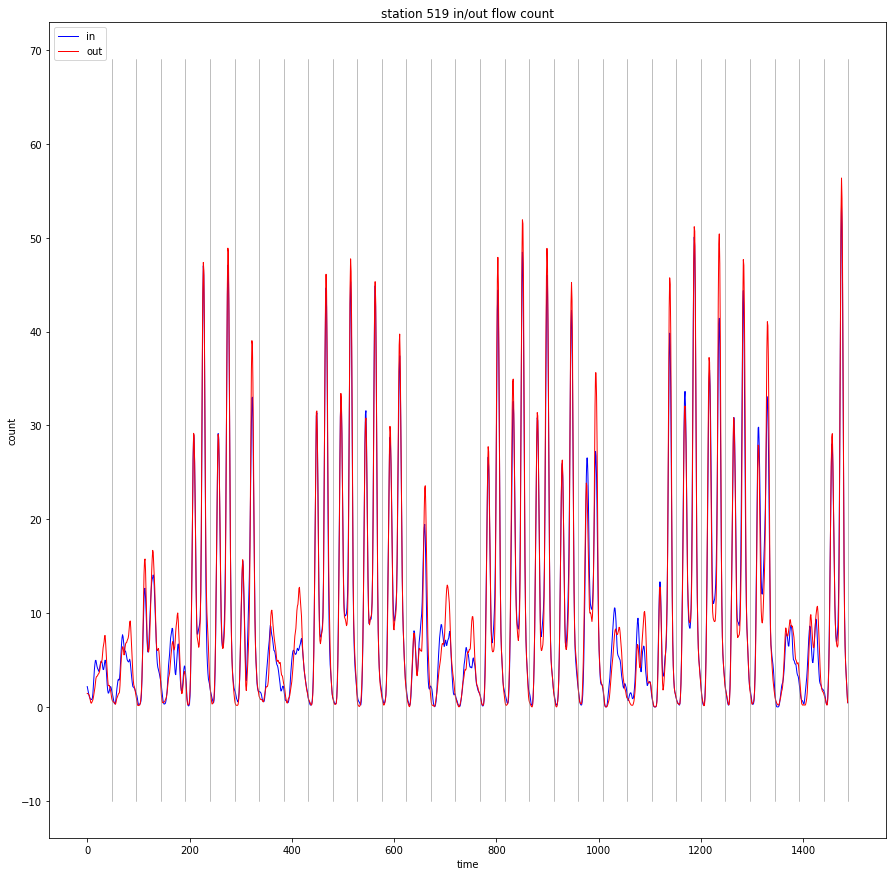

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

data=pd.read_csv('./inout_flow_data.csv')

d=data.loc[data['station_id']==519,:]

inf = lowess(d['in_flow_count'], d['time'], frac=0.007, it=0)
outf = lowess(d['out_flow_count'], d['time'], frac=0.007, it=0)

plt.figure(figsize=(15,15))
plt.plot(inf[:,0],inf[:,1],color='blue',label='in',linewidth=1.0)
plt.plot(outf[:,0],outf[:,1],color='red',label='out',linewidth=1.0)
a=[]
for i in range(-10,70):
    a.append(i)
for i in range(1,32):
	plt.plot([48*i]*80,a,color='gray',linewidth=0.5)
plt.title('station 519 in/out flow count')
plt.xlabel('time')
plt.ylabel('count')
plt.legend()
plt.show()

** Distance: 72.25 ** (By euclidean distance)

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from statsmodels.nonparametric.smoothers_lowess import lowess

data=pd.read_csv('./inout_flow_data.csv')

d=data.loc[data['station_id']==519,:]

inf = lowess(d['in_flow_count'], d['time'], frac=0.007, it=0)
outf = lowess(d['out_flow_count'], d['time'], frac=0.007, it=0)

print(pairwise_distances([inf[:,1],outf[:,1]],metric='euclidean'))

[[  0.          72.24848796]
 [ 72.24848796   0.        ]]


## Query some interesting things

我想從大家借腳踏車的時間來看數據，於是
```sql
select tm%48,sum(out_c)
from iodata
group by tm%48
order by sum(out_c) desc;
```
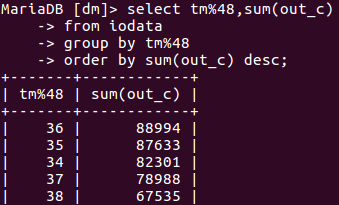
從這些數值，發現借腳踏車的時間大多在晚上6~8點，可能是放學或下班之後的交通所需

```sql
select tm%48,sum(in_c)
from iodata
group by tm%48
order by sum(in_c) desc;
```
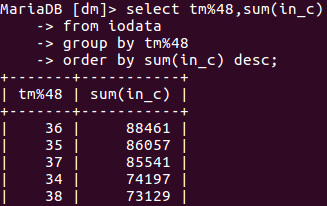
再來看還車時間，發現時間都跟方才的借車時間差不多，所以可能只是短時間的租借

```sql
select tm,sum(out_c)
from iodata
group by tm
order by sum(out_c) desc
limit 20;
```
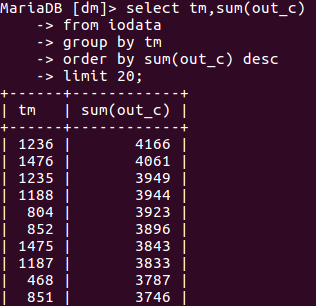

```sql
select tm,sum(in_c)
from iodata
group by tm
order by sum(in_c) desc
limit 20;
```
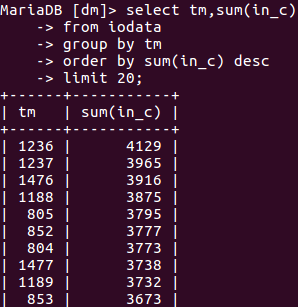

再來查了整個月份的租借時間統計，從上面這兩張圖可以支持剛剛說的'短時間租借'的推測，可以發現in/out兩張圖的時間是幾乎可以完全對照的，因此大概可以得到：那個地區的人，借車時間大約在晚上6~8點的短時間租借，用途可能是放學或下班之後的交通方式